# PRESELECCIÓN DE VARIABLES

## IMPORTACIÓN DE PAQUETES

In [102]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

import statsmodels.api as sm

## IMPORTAR LOS DATOS

### Cargar los datos

In [103]:
df = pd.read_pickle('../../02_Datos/03_Trabajo/num_resultado_eda.pickle')
df.head()

,age,distance_station,stores,latitude,longitude,price,year,mes
0,32.0,84.87882,10,24.98298,121.54024,37.9,2012,12
1,19.5,306.59470,9,24.98034,121.53951,42.2,2012,12
2,13.3,561.98450,5,24.98746,121.54391,47.3,2013,8
3,13.3,561.98450,5,24.98746,121.54391,54.8,2013,7
4,20.3,287.60250,6,24.98042,121.54228,46.7,2013,6


Quitamos atípicos detectados en la The Best Estimator --> 85 y 273

In [104]:
df = df.drop(index = [85])

### Separar predictoras y target

In [105]:
x = df.drop(columns= 'price').copy()
y = df.price.copy()

## MÉTODOS SUPERVISADOS

### MUTUAL INFORMATION

#### Crear función para mostrar resultado

In [106]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index= x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending= False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return (ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,10))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable, fontsize= 8)
        return(g)

#### Calcular y revisar

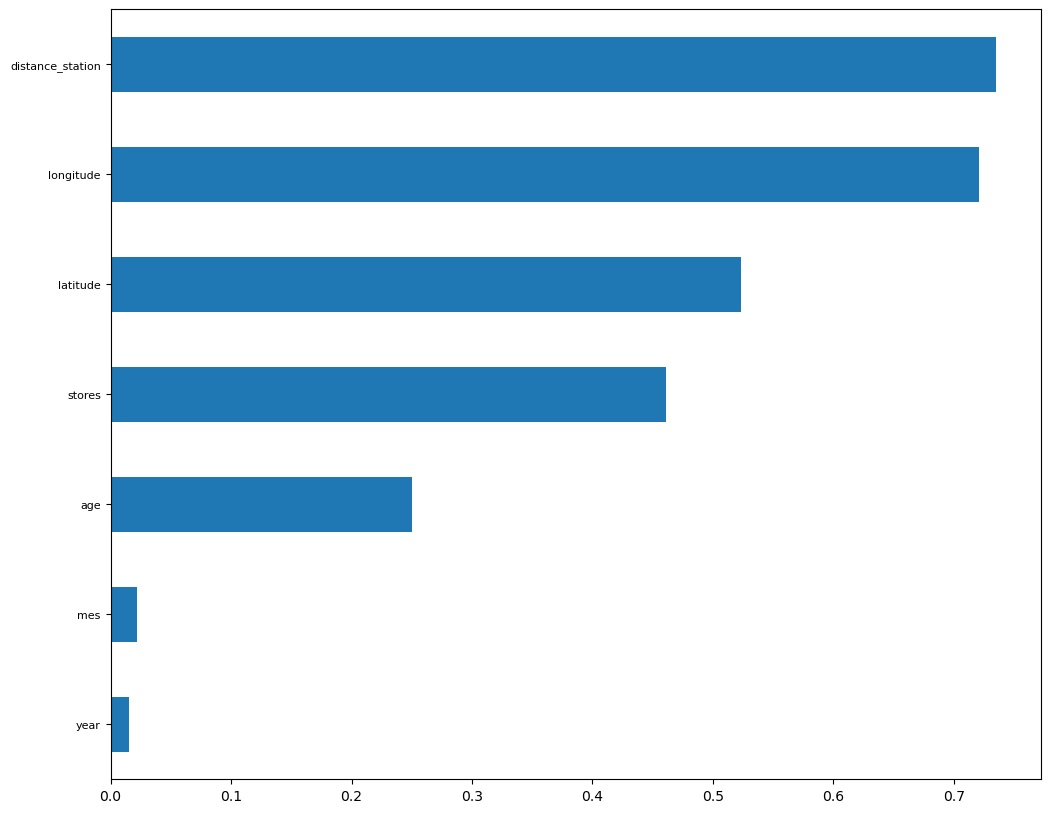

In [107]:
mutual_selector = mutual_info_regression(x,y)
rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [108]:
posicion_variable_limite = 7

##### Extrar los nombres de las que entran

In [109]:
entrar_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite]
entrar_mi

,variable,importancia_mi,ranking_mi
1,distance_station,0.735251,0
4,longitude,0.720525,1
3,latitude,0.523451,2
2,stores,0.460702,3
0,age,0.250456,4
6,mes,0.021721,5
5,year,0.015513,6


In [110]:
entrar_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable
entrar_mi

1    distance_station
4           longitude
3            latitude
2              stores
0                 age
6                 mes
5                year
Name: variable, dtype: object

##### Crear el dataframe con la selección

In [111]:
x_mi = x[entrar_mi].copy()
x_mi

,distance_station,longitude,latitude,stores,age,mes,year
0,84.87882,121.54024,24.98298,10,32.0,12,2012
1,306.59470,121.53951,24.98034,9,19.5,12,2012
2,561.98450,121.54391,24.98746,5,13.3,8,2013
3,561.98450,121.54391,24.98746,5,13.3,7,2013
4,287.60250,121.54228,24.98042,6,20.3,6,2013
...,...,...,...,...,...,...,...
285,2175.74400,121.51243,24.96330,3,18.5,6,2013
286,4082.01500,121.50381,24.94155,0,13.7,1,2013
287,390.96960,121.53986,24.97923,7,18.8,4,2013
288,104.81010,121.54067,24.96674,5,8.1,1,2013


### RECURSIVE FEATURE ELIMINATION

#### Instanciar

In [112]:
rfe = RFECV(estimator= XGBRegressor(n_jobs = -1, eval_metric = 'merror'), step= 3, cv=3, min_features_to_select= 3)

#### Entrenar

In [113]:
rfe.fit(x,y)

RFECV(cv=3,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric='merror',
                             feature_types=None, gamma=None, gpu_id=None,
                             grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=None,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=-1, num_parallel_tree=None, predictor=None,
                             random_state=None, ...),
      min_features_to_select=3, step=3)

In [114]:
pd.DataFrame(rfe.cv_results_).sort_values(by= 'mean_test_score')


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
1,0.715597,0.022807,0.741432,0.719400,0.685957
0,0.750503,0.016783,0.773088,0.732892,0.745529
2,0.755257,0.030886,0.795852,0.748919,0.720999


### Extraer los nombres de las que entran

In [115]:
entran_rfe = x.columns[rfe.support_]
entran_rfe

Index(['age', 'distance_station', 'stores', 'latitude', 'longitude', 'year',
       'mes'],
      dtype='object')

In [116]:
x_rfe = x[entran_rfe].copy()
x_rfe.head()

,age,distance_station,stores,latitude,longitude,year,mes
0,32.0,84.87882,10,24.98298,121.54024,2012,12
1,19.5,306.59470,9,24.98034,121.53951,2012,12
2,13.3,561.98450,5,24.98746,121.54391,2013,8
3,13.3,561.98450,5,24.98746,121.54391,2013,7
4,20.3,287.60250,6,24.98042,121.54228,2013,6


### PERMUTATION IMPORTANCE

#### Crear una función para mostrar el resultado

In [117]:
def ranking_per(predictoras, permutacion):
    ranking_per = pd.DataFrame({'variable':predictoras.columns, 'importancia_per':permutacion.importances_mean}).sort_values(by='importancia_per', ascending= False)
    ranking_per['ranking_per'] =  np.arange(0, ranking_per.shape[0])
    return ranking_per

#### Instanciar y entrenar

In [118]:
import warnings
warnings.filterwarnings(action= 'ignore', message = r'.*Use subset.*of np.ndarray is not recommended')
xgb = XGBRegressor(use_label_encoder = False, n_jobs= -1, eval_metric = 'auc')
xgb.fit(x,y)
permutacion = permutation_importance(xgb, 
                                     x, y,
                                     scoring= 'neg_mean_absolute_error',
                                     n_repeats= 5,
                                     n_jobs= -1)

#### Revisarla salida

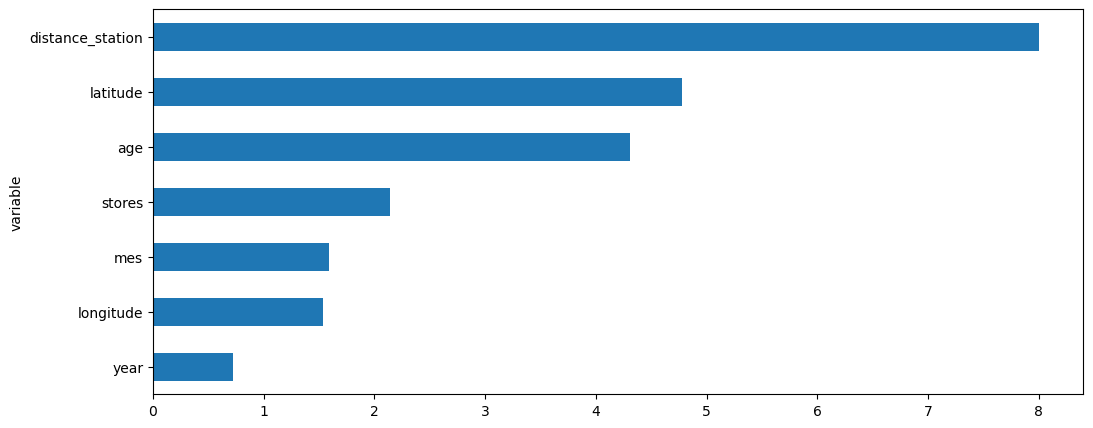

In [119]:
rank_per = ranking_per(x, permutacion)
rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,5));

In [120]:
rank_per

,variable,importancia_per,ranking_per
1,distance_station,7.998451,0
3,latitude,4.776824,1
0,age,4.309354,2
2,stores,2.140036,3
6,mes,1.590835,4
4,longitude,1.534857,5
5,year,0.718169,6


#### Revisar las variables que pasan

##### Definir la posición de la última variable que a a entrar

In [121]:
posicion_variable_limite = 6

##### Extraer los nombres de las que entran

In [122]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable
entran_per

1    distance_station
3            latitude
0                 age
2              stores
6                 mes
4           longitude
Name: variable, dtype: object

##### crear el dataframe con la selección

In [123]:
x_per = x[entran_per].copy()
x_per.head()

,distance_station,latitude,age,stores,mes,longitude
0,84.87882,24.98298,32.0,10,12,121.54024
1,306.59470,24.98034,19.5,9,12,121.53951
2,561.98450,24.98746,13.3,5,8,121.54391
3,561.98450,24.98746,13.3,5,7,121.54391
4,287.60250,24.98042,20.3,6,6,121.54228


## SELECCIONAR EL MÉTODO FINAL (ANTERIORES)

In [124]:
x_preselecionado = x_per
x_preselecionado.head()

,distance_station,latitude,age,stores,mes,longitude
0,84.87882,24.98298,32.0,10,12,121.54024
1,306.59470,24.98034,19.5,9,12,121.53951
2,561.98450,24.98746,13.3,5,8,121.54391
3,561.98450,24.98746,13.3,5,7,121.54391
4,287.60250,24.98042,20.3,6,6,121.54228


## MÉTODOS NO SUPERVISADOS

### CORRELACIÓN

#### Crear una función para mostrar el resultado

In [125]:
def correlaciones_fuertes(df, lim_inf = 0.3, lim_sup = 1, drop_dupli = True):
    #Calcula la matriz de correlación
    c= df.corr().abs()
    c= c.unstack()
    c= pd.DataFrame(c).reset_index()
    c.columns = ['var1', 'var2', 'corr']
    c = c.loc[(c['corr'] > lim_inf) & (c['corr'] < lim_sup), :].sort_values(by= 'corr', ascending= False)
    c = c if drop_dupli == False else c.drop_duplicates(subset= ['corr'])
    return c


#### Calcular

In [126]:
cor_finales = correlaciones_fuertes(x_preselecionado)

#### Revisar Agregado

In [127]:
cor_finales.var1.value_counts()

distance_station    3
latitude            2
stores              1
Name: var1, dtype: int64

#### Revisar detalle

In [128]:
cor_finales.head(50)

,var1,var2,corr
5,distance_station,longitude,0.777732
3,distance_station,stores,0.646219
1,distance_station,latitude,0.585971
9,latitude,stores,0.457492
23,stores,longitude,0.433648
11,latitude,longitude,0.387535


## SELECCIONAR VARIABLES A ELIMINAR

In [129]:
x_preselecionado.columns

Index(['distance_station', 'latitude', 'age', 'stores', 'mes', 'longitude'], dtype='object')

#### Filtrar variables

In [130]:
a_eliminar = ['longitude']
x_preselecionado.drop(columns= a_eliminar, inplace= True)
x_preselecionado.columns.to_list()

['distance_station', 'latitude', 'age', 'stores', 'mes']

### GUARDAR DATASETS TRAS PRESELECCIÓN DE VARIABLES

#### Definir los nombres de los archivos

In [131]:
nombre_x_preselecionado = '../../02_Datos/03_Trabajo/' + 'x_preselecionado.pickle'
nombre_y_preselecionado = '../../02_Datos/03_Trabajo/' + 'y_preselecionado.pickle'

#### Guardar los Datasets

In [132]:
#Predictoras
x_preselecionado.to_pickle(nombre_x_preselecionado)

#Target
y_preselecionado = y.copy()
y_preselecionado.to_pickle(nombre_y_preselecionado)

#### Guardar los nombres de las variables finales

In [133]:
x_preselecionado.columns.to_list()

nombre_variables_finales = '../../02_Datos/03_Trabajo/' + 'variables_finales.pickle'
x_preselecionado.iloc[:0].to_pickle(nombre_variables_finales)